## Analyzing cropland mapping predictions

This notebook visualizes and analyzes the outputs of Unet model's cropland predictions on PlanetScope NICFI basemap data.

## Setup

Install rasterio and connect Drive folder used to run analysis

In [1]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Libraries

In [49]:
import os
import re

import numpy as np
import numpy.ma as ma
import pandas as pd

import matplotlib.pyplot as plt
import cv2
import gdal
import rasterio
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Magic keywords for Ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Paths

In [4]:
config = {
    "working_dir" : "/content/gdrive/MyDrive/working_folder",
    "out_dir" : "refine15",
    
    "root_dir" : 
        "/content/gdrive/MyDrive/teaching/geog287387/data/fieldmapping/",
    "catalog_train_fn" : "catalog_ghana_ecaas_ejura_tain.csv",
    "catalog_pred_fn" : "catalog_predict_nicfi_retiled_ejura_tain_2020-11.csv"
}

# Visualize

## Predictions

In [78]:
pred_path = f'{config["working_dir"]}/{config["out_dir"]}/Inference_output'
preds = [f'{pred_path}/{file}' for file in os.listdir(pred_path)]
score_maps = [rasterio.open(p) for p in preds]

## Images

To get the images corresponding to the predictions, we have to use the prediction catalog and the name of the predictions. 

In [13]:
pred_cat = pd.read_csv(f'{config["root_dir"]}/{config["catalog_pred_fn"]}')
pred_cat

,tile_col,tile_row,tile,dir_gs,dir_os,type
0,298,572,tile539059,predict_tiles/tile539059_202011.tif,predict_tiles/tile539059_202011.tif,center
1,299,572,tile539060,predict_tiles/tile539060_202011.tif,predict_tiles/tile539060_202011.tif,center
2,298,573,tile539079,predict_tiles/tile539079_202011.tif,predict_tiles/tile539079_202011.tif,center
3,299,573,tile539080,predict_tiles/tile539080_202011.tif,predict_tiles/tile539080_202011.tif,center
4,298,574,tile539099,predict_tiles/tile539099_202011.tif,predict_tiles/tile539099_202011.tif,center
5,299,574,tile539100,predict_tiles/tile539100_202011.tif,predict_tiles/tile539100_202011.tif,center
6,298,575,tile539119,predict_tiles/tile539119_202011.tif,predict_tiles/tile539119_202011.tif,center
7,299,575,tile539120,predict_tiles/tile539120_202011.tif,predict_tiles/tile539120_202011.tif,center
8,299,576,tile539140,predict_tiles/tile539140_202011.tif,predict_tiles/tile539140_202011.tif,center
9,299,577,tile539160,predict_tiles/tile539160_202011.tif,predict_tiles/tile539160_202011.tif,center


In [32]:
colrow = [re.sub("class*.*score_c|_r|.tif", "", os.path.basename(p)) \
          for p in preds]

In [30]:
pred_cat["tile_col"].map(str) + pred_cat["tile_row"].map(str)

0    298572
1    299572
2    298573
3    299573
4    298574
5    299574
6    298575
7    299575
8    299576
9    299577
dtype: object

Fortunately, the images are in the same order in the catalog as the predictions are listed, so we can do one to one comparisons. 

In [35]:
images = [rasterio.open(f'{config["root_dir"]}{img["dir_os"]}') \
         for row, img in pred_cat.iterrows()]

### Function to rescale image for plotting

In [72]:
def rescale_image(image, bands=(0, 1, 2, 3)):
    img = reshape_as_image(image.read())[:,:,bands]
    max_vals = [img[:, :, band].max() for band in range(img.shape[-1])]
    img = img.astype('float64')
    for band in bands:
        band_vals = img[:, :, band]
        img[:, :, band] = band_vals / max_vals[band]

    return img

### Function to plot side by side images

In [100]:
def image_plotter(image, prediction, fsize):

    fig, ax_arr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=fsize)
    ax1, ax2 = ax_arr.ravel()
    
    ax1.imshow(image) 
    ax1.set_title('Original  image')

    ax2.imshow(prediction)
    ax2.set_title('Score map')

    for ax in ax_arr.ravel():
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

In [96]:
img_rescaled = rescale_image(images[0])
score = score_maps[0].read()[0]

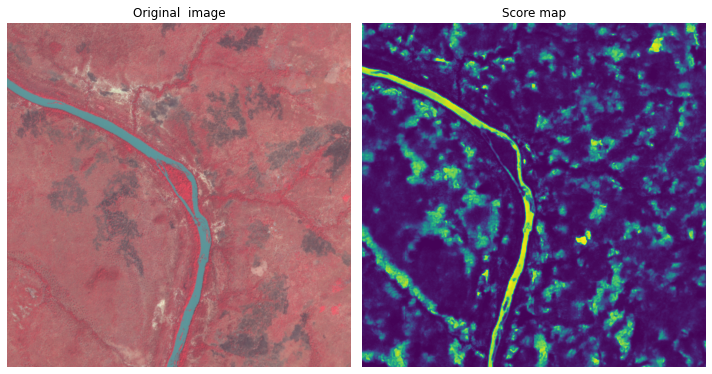

In [101]:
image_plotter(img_rescaled[:,:,(3,2,1)], score, fsize = (10, 10))

In [127]:
cropland = np.ma.masked_where(score_mask < 50, score_mask)